 # Programming Assignment - FakeFinder : Building an AI to Detect AI-Generated Images


¿Pueden las máquinas detectar sus propias creaciones?

¡Bienvenido, **AI Explorer**! En esta tarea, te embarcarás en un viaje hacia el dinámico paisaje del AutoML, donde descubrirás cómo la inteligencia artificial puede aprender a optimizarse a sí misma.
¿El objetivo de tu expedición? Equipar a tu AI Explorer con las habilidades para distinguir imágenes auténticas de creaciones generadas por modelos de IA de última generación como Stable Diffusion, MidJourney y DALL·E.

En esta exploración exhaustiva de la detección de autenticidad de imágenes, dominarás las siguientes técnicas:

* Construir **Redes Neuronales Convolucionales (CNNs) flexibles** utilizando `nn.Sequential` para crear arquitecturas adaptables de forma dinámica, basadas en hiperparámetros variables como el número de capas y los tamaños de los filtros.
* Diseñar un **espacio de búsqueda de hiperparámetros** robusto para que Optuna optimice los modelos.
* Definir e implementar una **función objetivo** que guíe el proceso automatizado de ajuste de hiperparámetros.
* Ejecutar un estudio de Optuna para descubrir configuraciones de CNN efectivas.
* Analizar **métricas de eficiencia** para refinar tu selección entre los modelos de CNN con mejor rendimiento dentro del estudio.

¡Ahora trazarás el rumbo para construir un FakeFinder robusto y veloz!

---
<a name='submission'></a>

<h4 style="color:green; font-weight:bold;">TIPS FOR SUCCESSFUL GRADING OF YOUR ASSIGNMENT:</h4>

* All cells are frozen except for the ones where you need to submit your solutions or when explicitly mentioned you can interact with it.

* In each exercise cell, look for comments `### START CODE HERE ###` and `### END CODE HERE ###`. These show you where to write the solution code. **Do not add or change any code that is outside these comments**.

* You can add new cells to experiment but these will be omitted by the grader, so don't rely on newly created cells to host your solution code, use the provided places for this.

* Avoid using global variables unless you absolutely have to. The grader tests your code in an isolated environment without running all cells from the top. As a result, global variables may be unavailable when scoring your submission. Global variables that are meant to be used will be defined in UPPERCASE.

* To submit your notebook for grading, first save it by clicking the 💾 icon on the top left of the page and then click on the `Submit assignment` button on the top right of the page.
---

## Table of Contents

- [Imports](#0)
- [1 - Preparing the Expedition: Data Inspection](#1)
    - [1.1 - Exploring real vs. fake images](#1-1)
- [2 - Crafting Your AI Explorer: Building a Flexible CNN](#2)
    - **[Exercise 1 - FlexibleCNN](#ex-1)**
- [3 - Charting New Territories: Designing the Hyperparameter Search Space](#3)
    - **[Exercise 2 - design_search_space](#ex-2)**
- [4 - Letting AI Take the Lead: Implementing the Optuna Objective](#4)
    - **[Exercise 3 - objective_function](#ex-3)**
- [5 - Navigating the Hyperparameter Landscape: Running the Optuna Study](#5)
    - [5.1 - Analyzing the Results: Evaluating the Best Models](#5-1)
        - **[Exercise 4 - get_trainable_params](#ex-4)**
- [6 - (Optional) Evaluating the model with alternative metrics](#6)
    - [6.1 - Precision and Recall](#6-1)

In [ ]:
#!tar -czf - AIvsReal_sampled/train/real | split -b 200M - "parte_real_"
#!cat parte_real_a* > train_real.tar.gz

In [ ]:
#!tar -czf comprimido_train_real.tar.gz AIvsReal_sampled/train/real
#!tar -xvzf train_fake.tar.gz

<a name='0'></a>
## Imports

In [2]:
from pprint import pprint

import matplotlib as mpl
import matplotlib.pyplot as plt
import optuna
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchmetrics.classification import Accuracy, Precision, Recall

from helper_utils import evaluate_model, extract_attr, get_data_loaders, training_epoch

In [4]:
import helper_utils
#import unittests

In [5]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using Device: {DEVICE}")

Using Device: cpu


<a name='1'></a>
## 1 - Preparando la Expedición: Inspección de Datos

Trabajarás con una colección curada de imágenes que muestra tanto imágenes reales como creaciones sintéticas de modelos generativos de última generación.
El conjunto de datos que explorarás es un subconjunto del dataset [AI-Generated Images vs Real Images](https://www.kaggle.com/datasets/tristanzhang32/ai-generated-images-vs-real-images).

El dataset original contiene 60,000 imágenes: la mitad generada por modelos de IA avanzados (Stable Diffusion, MidJourney y DALL·E), y la otra mitad imágenes genuinas de fuentes como Pexels, Unsplash y WikiArt. 
Para que tu exploración sea eficiente y manejable, trabajarás con un subconjunto cuidadosamente seleccionado:
- **5,000 imágenes** para entrenamiento (training).
- **1,000 imágenes** para pruebas (testing).



Las imágenes están organizadas en dos carpetas principales (`train` y `test`), cada una con dos subdirectorios:
- `real`: imágenes genuinas.
- `fake`: imágenes sintéticas generadas por IA.

Nota: Algunas de las imágenes etiquetadas como `real` son en realidad dibujos en lugar de fotografías.

<a name='1-1'></a>
### 1.1 - Explorando imágenes reales vs. falsas (fake)

Es hora de explorar visualmente el terreno que vas a recorrer. 
Visualizarás algunas imágenes al azar —tanto del conjunto de entrenamiento como del de prueba— para familiarizarte con ambas categorías.

Aquí iterarás a través del dataset, mostrando un puñado de imágenes representativas para una exploración inicial.
El módulo `helper_utils` proporciona una función para mostrar imágenes aleatorias del conjunto de datos.

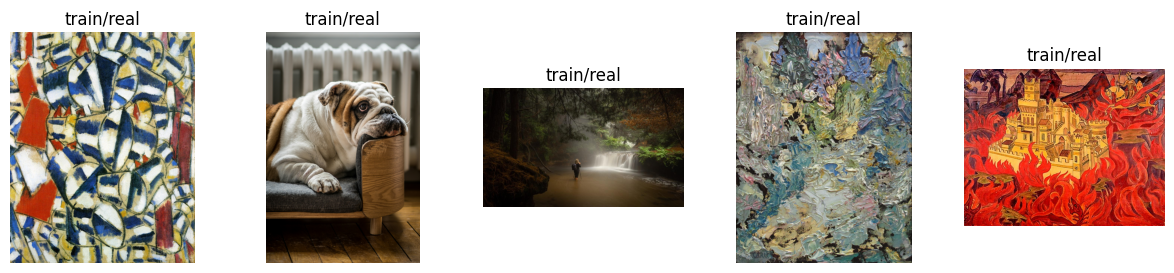

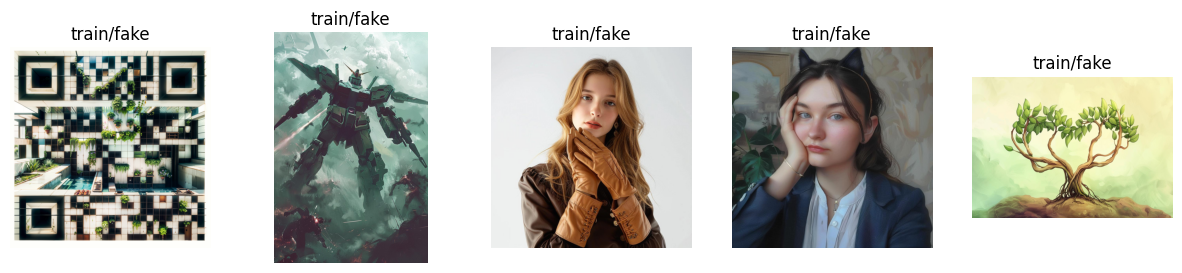

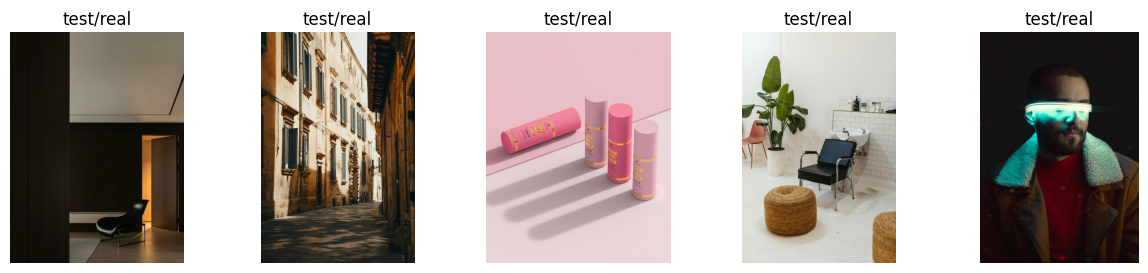

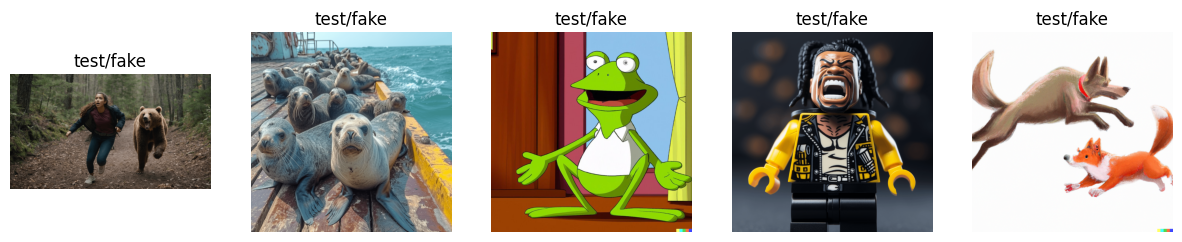

In [6]:
AIvsReal_path = "./AIvsReal_sampled"  

# Display example images
for split in ['train', 'test']:
    for category in ['real', 'fake']:
        helper_utils.show_random_images(split, category, AIvsReal_path, num_images=5)

<a name='2'></a>
## 2 - Creando tu AI Explorer: Construyendo una CNN Flexible

En esta sección, construirás el núcleo de tu AI Explorer: una **red neuronal convolucional (CNN) flexible**. 
En lugar de construir una arquitectura de CNN fija, definirás un modelo que se construye dinámicamente basándose en los parámetros proporcionados, como el número de capas, tamaños de filtros y funciones de activación.

Esta parametrización permite adaptar la red a tareas y datasets específicos, mejorando su efectividad sin la necesidad de rediseñarla desde cero.
Además, la escalabilidad de este enfoque garantiza que la red pueda adaptarse de manera eficiente a diversas complejidades, desde tareas simples hasta avanzadas, haciéndola versátil en sus aplicaciones.

Esta flexibilidad será crucial más adelante, cuando automatices la exploración de arquitecturas utilizando Optuna.

<a name='ex-1'></a>
### Ejercicio 1 - FlexibleCNN

**Tu Tarea:**

Para la configuración de la red neuronal `features` (lograda con [`ModuleList`](https://docs.pytorch.org/docs/stable/generated/torch.nn.ModuleList.html)):

* **`__init__`**: 
    * Construye cada `convolutional_block` utilizando un contenedor `Sequential` compuesto por:
        * Una capa convolucional 2d.
        * Una [capa de normalización por lotes (batch normalization)](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) 2d para normalizar la salida de la capa convolucional.
        * Una función de activación ReLU.
        * Una capa de max pooling 2d.
    * Asegúrate de que cada bloque convolucional se conecte correctamente configurando adecuadamente los `in_channels` para las capas subsiguientes.


* **`_create_classifier`**: 
    * Utiliza `nn.Sequential` para construir la estructura del clasificador con los siguientes componentes:
        - Capa de dropout (proporcionada).
        - Capa fully connected (lineal).
        - Función de activación ReLU (proporcionada).
        - Capa de dropout (proporcionada).
        - Capa de salida lineal.

* **`forward`**: 
    * Aplica un `flatten` a la salida después de la última capa en el módulo `.features` para prepararla para la capa fully connected del clasificador, manteniendo intacta la dimensión del batch.
    * Extrae el tamaño del tensor aplanado `x` para determinar el tamaño de entrada de la capa fully connected.
    * Crea el clasificador basándote en el atributo `._flattened_size`.


<details>
<summary><b><font color="green">Pistas de Código Adicionales (Haz clic para expandir si te has estancado)</font></b></summary>

Si te encuentras estancado, aquí tienes un desglose más detallado.

**Para el método `__init__`:**
* El `convolutional_block` es un contenedor `nn.Sequential` que definirás dentro del bucle for.
* Las capas dentro de él deben inicializarse de la siguiente manera:
    * `nn.Conv2d`: Usa los `in_channels` actuales, los `out_channels` para esta capa, el `kernel_size` especificado y el `padding` calculado.
    * `nn.BatchNorm2d`: El argumento `num_features` para esta capa debe coincidir con los `out_channels` de la capa convolucional precedente.
    * `nn.MaxPool2d`: Establece el `kernel_size` en `2` y el `stride` en `2`.
* Para actualizar los canales para la siguiente iteración, usa esta lógica:
    * > `in_channels = los out_channels de la capa actual`

**Para el método `_create_classifier`:**
* Este es otro contenedor `nn.Sequential`.
* La primera capa `nn.Linear` debe mapear desde `flattened_size` hasta `self.fc_size`.
* La capa `nn.Linear` final debe mapear desde `self.fc_size` hasta `self.num_classes`.

**Para el método `forward`:**
* Para aplanar el tensor `x`, puedes usar pseudocódigo como este:
    * > `x = aplanar el tensor x, comenzando desde la dimensión 1`
* Para obtener el tamaño para el clasificador, el pseudocódigo es:
    * > `self._flattened_size = obtener el tamaño de la dimensión 1 del tensor x`
* Para crear el clasificador, simplemente llama al método de ayuda que ya implementaste:
    * > `llamar al método _create_classifier, pasándole self._flattened_size`

</details>

In [87]:
# CLASE CALIFICADA: FlexibleCNN

class FlexibleCNN(nn.Module):
    """
    Una red neuronal convolucional (CNN) personalizable para la clasificación de imágenes.
    Construye dinámicamente bloques convolucionales basados en hiperparámetros proporcionados
    como el número de capas, tamaños de filtros, tamaños de kernel y tasas de dropout.
    """

    def __init__(
        self, n_layers, n_filters, kernel_sizes, dropout_rate, fc_size, num_classes=2
    ):
        """
        Inicializa la FlexibleCNN.

        Args:
            n_layers (int): Número de capas convolucionales.
            n_filters (list): Número de filtros para cada capa convolucional.
            kernel_sizes (list): Tamaños de kernel para cada capa convolucional.
            dropout_rate (float): Tasa de dropout para regularización.
            fc_size (int): Número de unidades en la capa fully connected.
            num_classes (int): Número de clases de salida.
        """
        super(FlexibleCNN, self).__init__()

        self.num_classes = num_classes
        
        self.features = nn.ModuleList()
        in_channels = 3  # Imágenes de entrada RGB

        ### START CODE HERE ###
        
        for i in range(n_layers): 
            # Crear capa convolucional con parámetros dinámicos
            # Extraer el número de filtros y el tamaño del kernel para la capa actual, de n_filters y kernel_sizes
            out_channels = n_filters[i] 
            kernel_size = kernel_sizes[i] 
            
            # Calcular el padding para mantener las dimensiones espaciales o reducirlas controladamente
            padding = (kernel_size - 1) // 2 

            # Crear un bloque convolucional, utilizando un contenedor `nn.Sequential` para agrupar capas
            convolutional_block = nn.Sequential(
                # Añadir una capa convolucional `Conv2d` con los parámetros: `in_channels`, `out_channels`, `kernel_size` y `padding`
                nn.Conv2d(in_channels= in_channels, out_channels= out_channels, kernel_size= kernel_size, padding= padding),
                # Añadir una capa de normalización por lotes `BatchNorm2d` con `num_features` como `out_channels` 
                nn.BatchNorm2d(num_features= out_channels),
                # Añadir una activación ReLU
                nn.ReLU(), 
                # Añadir una capa MaxPool2d `MaxPool2d`, con `kernel_size=2` y `stride=2`
                nn.MaxPool2d(kernel_size= 2, stride= 2)
            )
                
            # Añadir el bloque convolucional al ModuleList de features
            self.features.append(convolutional_block)

            # Actualizar in_channels para la siguiente capa (los canales de entrada de la siguiente capa son los canales de salida de la actual)
            in_channels = out_channels
            

        ### END CODE HERE ###

        self.dropout_rate = dropout_rate
        self.fc_size = fc_size        
                
        # El clasificador se inicializará después de calcular el tamaño aplanado (flattened size)
        self.classifier = None  
        self._flattened_size = None 
        

    def _create_classifier(self, flattened_size):
        """
        Crea la parte del clasificador fully connected del modelo basada en el tamaño de las características aplanadas.

        Args:
            flattened_size (int): Tamaño de los mapas de características aplanados.
        """
        ### START CODE HERE ###

        # Crear el clasificador usando un contenedor Sequential
        self.classifier = nn.Sequential(

            # Añadir una capa de dropout con la tasa de dropout definida en la inicialización
            nn.Dropout(p=self.dropout_rate), 
            # Añadir una capa fully connected `Linear` con `in_features=flattened_size` y `out_features` como `fc_size`
            nn.Linear(in_features= flattened_size, out_features= self.fc_size),
            # Función de activación
            nn.ReLU(), 
            # Otra capa de dropout
            nn.Dropout(p=self.dropout_rate), 
            # Añadir la capa fully connected final con `in_features` como `fc_size` y `out_features` como `num_classes`
            nn.Linear(in_features=  self.fc_size, out_features= self.num_classes),
        ) 

        ### END CODE HERE ###

    def forward(self, x):
        """
        Define el paso hacia adelante (forward pass) de la FlexibleCNN.

        Args:
            x (torch.Tensor): Tensor de entrada (batch de imágenes).

        Returns:
            torch.Tensor: Tensor de salida (puntuaciones de clasificación).
        """
        # Aplicar las capas de extracción de características convolucionales
        for layer in self.features:
            x = layer(x)

        ### START CODE HERE ###

        # Aplanar la salida x para el clasificador (start_dim=1 para mantener la dimensión del batch)
        x = torch.flatten(x, 1)

        # Crear dinámicamente el clasificador si no existe
        if self.classifier is None:
            # Obtener el tamaño de los mapas de características aplanados desde el tensor x
            self._flattened_size = x.size(1)

            # Crear el clasificador con el `_flattened_size` 
            self._create_classifier(self._flattened_size)

        ### END CODE HERE ###
            
            # Extract the device from the input tensor
            device = x.device
            
            # Move the classifier to the same device as the input tensor, to ensure compatibility with GPU/CPU
            if self.classifier is not None:
                self.classifier.to(device)

        # Classification
        return self.classifier(x)

In [88]:
# Create the model with specific parameters
n_layers = 3
n_filters = [16, 32, 64]
kernel_sizes = [3, 3, 3]
dropout_rate = 0.5
fc_size = 128

model = FlexibleCNN(
    n_layers=n_layers,
    n_filters=n_filters,
    kernel_sizes=kernel_sizes,
    dropout_rate=dropout_rate,
    fc_size=fc_size,
).to(DEVICE)

resolution = 32
x_sample = torch.randn(1, 3, resolution, resolution).to(DEVICE)  # Example input tensor


# Forward pass through the model
output = model(x_sample)

# print the model features architecture
print(f"FlexibleCNN features architecture:\n{model.features}")

print(f"FlexibleCNN classifier architecture:\n{model.classifier}")

FlexibleCNN features architecture:
ModuleList(
  (0): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)
FlexibleCNN classifier architecture:
Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1)

 #### Expected Output:

 ```
FlexibleCNN features architecture:
ModuleList(
  (0): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)
FlexibleCNN classifier architecture:
Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=1024, out_features=128, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=128, out_features=2, bias=True)
)
 ```

In [ ]:
# Test your code!
unittests.exercise_1(FlexibleCNN)

<a name='3'></a>
## 3 - Trazando Nuevos Territorios: Diseñando el Espacio de Búsqueda de Hiperparámetros

Con tu arquitectura de CNN flexible lista, el siguiente paso de tu expedición consiste en trazar el mapa del paisaje de los hiperparámetros.
Crearás un espacio de búsqueda detallado utilizando **Optuna**, lo que permitirá la exploración automática de hiperparámetros tanto de arquitectura como de entrenamiento.  
Definir cuidadosamente este espacio de búsqueda permite que tu AI Explorer navegue eficientemente entre diferentes configuraciones para identificar los modelos óptimos.



<a name='ex-2'></a>
### Ejercicio 2 - design_search_space

**Tu Tarea:**

Implementar un espacio de búsqueda estructurado para Optuna que seleccione valores para los hiperparámetros de arquitectura y de entrenamiento.

* Utiliza los métodos `trial.suggest_int`, `trial.suggest_float` y `trial.suggest_categorical` para definir estos parámetros (para un resumen de las distribuciones disponibles consulta [Optuna Trial](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html)).
* Asegúrate de utilizar los tipos correctos (`int`, `float`, `categorical`) para cada hiperparámetro y garantiza que los límites sean los propuestos dentro del código. 
* **Al usar los métodos `trial.suggest_`, siempre proporciona un nombre para el hiperparámetro. Los nombres utilizados coinciden exactamente con los definidos en el código para mantener la consistencia.**

Tu espacio de búsqueda debe definir claramente rangos u opciones para:

* **`Arquitectura de la CNN`**: 
>    * Número de capas convolucionales. (`n_layers`)
>    * Número de filtros para cada capa convolucional. (`n_filters_layer{i}`)
>    * Tamaños de kernel. (`kernel_size_layer{i}`)
>    * Tasas de dropout. (`dropout_rate`)
>    * Número de unidades en la capa fully connected (densa). (`fc_size`)

* **`Parámetros de Entrenamiento`**: 
>    * Tasa de aprendizaje (learning rate). (`learning_rate`)
>    * Resolución de imagen. (`resolution`)
>    * Tamaño del lote (batch size). (`batch_size`)



<details>
<summary><b><font color="green">Pistas de Código Adicionales (Haz clic para expandir si te has estancado)</font></b></summary>

Si necesitas ayuda, aquí tienes una guía más detallada para cada hiperparámetro.

**Hiperparámetros de la Arquitectura CNN:**

* **n_layers**:
    * > `n_layers = usa el objeto trial para sugerir un entero llamado "n_layers" entre 1 y 3`
* **n_filters**:
    * Esta es una comprensión de lista. Para cada capa `i`, necesitas:
    * > `sugerir un entero llamado f"n_filters_layer{i}" entre 8 y 64, con un paso (step) de 8`
* **kernel_sizes**:
    * Similar a los filtros, es una comprensión de lista. Para cada capa `i`:
    * > `sugerir un entero llamado f"kernel_size_layer{i}" entre 3 y 5, con un paso de 2`
* **dropout_rate**:
    * > `dropout_rate = usa el objeto trial para sugerir un float llamado "dropout_rate" entre 0.1 y 0.5`
* **fc_size**:
    * > `fc_size = usa el objeto trial para sugerir un entero llamado "fc_size" entre 64 y 512, con un paso de 64`

**Hiperparámetros de Entrenamiento:**

* **learning_rate**:
    * Esto requiere una escala logarítmica.
    * > `learning_rate = usa el objeto trial para sugerir un float llamado "learning_rate" entre 1e-4 y 1e-2, y establece el parámetro log en True`
* **resolution**:
    * Esta es una elección de una lista predefinida.
    * > `resolution = usa el objeto trial para sugerir un valor categórico llamado "resolution" de la lista [16, 32, 64]`
* **batch_size**:
    * Esta también es una elección de una lista.
    * > `batch_size = usa el objeto trial para sugerir un valor categórico llamado "batch_size" de la lista [8, 16]`

</details>

In [89]:
# FUNCIÓN CALIFICADA: design_search_space

def design_search_space(trial):
    """
    Diseña el espacio de búsqueda para la optimización de hiperparámetros del modelo FlexibleCNN.
    Esta función utiliza Optuna para sugerir hiperparámetros para la arquitectura de la CNN y el proceso de entrenamiento.
    
    Args:
        trial (optuna.Trial): Un objeto de prueba de Optuna utilizado para sugerir hiperparámetros.
    
    Returns:
        dict: Un diccionario que contiene los hiperparámetros sugeridos.    
    """
    # Hiperparámetros de la Arquitectura CNN

    ### START CODE HERE ###
    
    # Usa trial.suggest_* para configurar n_layers. Nómbralo "n_layers" y establécelo como un entero entre 1 y 3.
    n_layers = trial.suggest_int("n_layers", 1, 3)
       
    # Usa trial.suggest_* para configurar cada tamaño de filtro en n_filters.
    # Nombra cada tamaño de filtro como "n_filters_layer{i}" donde i es el índice de la capa y establécelo como un entero entre 8 y 64 con un paso de 8.
    n_filters = [ 
        trial.suggest_int(f"n_filters_layer{i}",8, 64, step= 8) for i in range(n_layers)
    ] 
    
    # Usa trial.suggest_* para configurar cada tamaño de kernel en kernel_sizes.
    # Nombra cada tamaño de kernel como "kernel_size_layer{i}" donde i es el índice de la capa y establécelo como un entero entre 3 y 5 con un paso de 2.
    kernel_sizes = [ 
        trial.suggest_int(f"kernel_size_layer{i}", 3, 5, step= 2) for i in range(n_layers)
    ] 

    # Usa trial.suggest_* para configurar dropout_rate, nómbralo "dropout_rate" y establécelo como un float entre 0.1 y 0.5.
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    
    # Usa trial.suggest_* para configurar fc_size, nómbralo "fc_size" y establécelo como un entero entre 64 y 512 con un paso de 64.
    fc_size = trial.suggest_int("fc_size", 64, 512, step = 64)

    
    # Hiperparámetros de Entrenamiento

    # Usa trial.suggest_* para configurar learning_rate, nómbralo "learning_rate" y establécelo como un float entre 1e-4 y 1e-2 con escala logarítmica (log=True).
    learning_rate = trial.suggest_float("learning_rate",1e-4, 1e-2, log=True)

    # Usa trial.suggest_* para configurar resolution, nómbralo "resolution" y establécelo como uno de estos valores [16, 32, 64].
    resolution = trial.suggest_categorical("resolution", [16,32,64])
    
    # Usa trial.suggest_* para configurar batch_size, nómbralo "batch_size" y establécelo como uno de estos valores [8, 16].
    batch_size = trial.suggest_categorical("batch_size", [8,16])
    
    ### END CODE HERE ###

    return {
        "n_layers": n_layers,
        "n_filters": n_filters,
        "kernel_sizes": kernel_sizes,
        "dropout_rate": dropout_rate,
        "fc_size": fc_size,
        "learning_rate": learning_rate,
        "resolution": resolution,
        "batch_size": batch_size,
    }

In [90]:
# Para verificar que la función design_search_space funciona correctamente, puedes ejecutarla con un trial fijo.

# Crear un trial fijo con hiperparámetros específicos
fixed_params = {
    "n_layers": 2,
    "n_filters_layer0": 16,
    "n_filters_layer1": 32,
    "kernel_size_layer0": 3,
    "kernel_size_layer1": 5,
    "dropout_rate": 0.001,
    "fc_size": 128,
    "learning_rate": 1e-3,
    "resolution": 32,
    "batch_size": 16,
}
toy_trial = optuna.trial.FixedTrial(fixed_params)

# Mostrar el espacio de búsqueda diseñado para el trial fijo
pprint(design_search_space(toy_trial))

{'batch_size': 16,
 'dropout_rate': 0.001,
 'fc_size': 128,
 'kernel_sizes': [3, 5],
 'learning_rate': 0.001,
 'n_filters': [16, 32],
 'n_layers': 2,
 'resolution': 32}


/tmp/ipykernel_1270/1896881460.py:34: UserWarning: The value 0.001 of the parameter 'dropout_rate' is out of the range of the distribution FloatDistribution(high=0.5, log=False, low=0.1, step=None).
  dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)


#### Expected Output:

```
{'batch_size': 16,
 'dropout_rate': 0.001,
 'fc_size': 128,
 'kernel_sizes': [3, 5],
 'learning_rate': 0.001,
 'n_filters': [16, 32],
 'n_layers': 2,
 'resolution': 32}
```

In [ ]:
# Test your code!
unittests.exercise_2(design_search_space)

<a name='4'></a> 
## 4 - Dejando que la IA tome el mando: Implementando el Objetivo de Optuna

Has trazado una arquitectura de modelo flexible y has delineado un espacio de búsqueda; ahora es momento de unirlo todo. 
En esta sección, implementarás la **función objetivo** (objective function) que impulsa el proceso de AutoML.
La función objetivo en Optuna encapsula los pasos necesarios para evaluar el rendimiento del modelo, como el accuracy, para cada conjunto de hiperparámetros muestreados, guiando así el proceso de optimización.

En el contexto actual, cada prueba (trial) consiste en entrenar el modelo Flexible CNN con un conjunto específico de hiperparámetros y evaluar su rendimiento en un conjunto de datos de validación.
`get_data_loaders`, `train_model` y `evaluate_model` son funciones auxiliares para facilitar el proceso de entrenamiento y evaluación, incluyendo la carga de datos, el entrenamiento del modelo y el cálculo del accuracy de validación.
Estos son envoltorios (wrappers) de conceptos que ya has utilizado en tareas anteriores, por lo que puedes concentrarte en la función objetivo en sí misma.



<a name='ex-3'></a>
### Ejercicio 3 - objective_function

Como se mencionó, nuestra función objetivo debe ejecutar un ciclo de entrenamiento completo, incluyendo la validación. 
Entre otros pasos, debe: definir los parámetros para cargar los datos, instanciar el modelo y, posteriormente, entrenar y evaluar el modelo.

**Tu tarea:**

Implementar la `objective_function` que Optuna utilizará para evaluar el rendimiento de varias configuraciones de hiperparámetros.

* Define `params` utilizando la función `design_search_space` que implementaste anteriormente.
* Completa el `transform` para redimensionar las imágenes a la resolución elegida.
* Instancia el modelo `FlexibleCNN` con los hiperparámetros muestreados.

<details>
<summary><b><font color="green">Pistas de Código Adicionales (Haz clic para expandir si te has estancado)</font></b></summary>

Si estás estancado, esta guía detallada debería ayudarte.

* **Obtener los parámetros**: Esta es una sola llamada a función.
    * > `params = llamar a la función design_search_space, pasándole el objeto trial`

* **Definir la transformación**: Solo necesitas completar la parte de `transforms.Resize`. El valor de la resolución está almacenado en tu diccionario `params`.
    * > `transforms.Resize((obtener la "resolution" de params, obtener la "resolution" de params))`

* **Instanciar el modelo**: Debes pasar los valores de tu diccionario `params` como argumentos al constructor de `FlexibleCNN`. Sigue el patrón que se muestra a continuación para todos los parámetros requeridos.
    * El primer argumento es `n_layers=params["n_layers"]`.
    * Haz lo mismo para `n_filters`, `kernel_sizes`, `dropout_rate` y `fc_size`.

</details>

In [91]:
# FUNCIÓN CALIFICADA: objective_function

def objective_function(trial, device, dataset_path, n_epochs=4, silent=False, test=False):
    """
    Función objetivo para que Optuna optimice los hiperparámetros del modelo FlexibleCNN.
    Args:
        trial (optuna.Trial): Un objeto de prueba de Optuna utilizado para sugerir hiperparámetros.
        n_epochs (int): Número de épocas para entrenar el modelo.
        silent (bool): Si es True, suprime la salida durante el entrenamiento y la evaluación.
        test (bool): Si es True, extrae atributos del trial para fines de evaluación.
    Returns:
        float: El accuracy del modelo en el conjunto de validación.
    """

    # === construcción del modelo, dataloaders ===
    
    ### START CODE HERE ###
    
    # usa design_search_space para obtener los parámetros para el trial
    params = design_search_space(trial)

    # añade el transform para redimensionar las imágenes a la resolución especificada en params
    transform = transforms.Compose([
            transforms.Resize((params["resolution"],params["resolution"])),
            transforms.ToTensor(), 
        ])

    # define el modelo usando la clase FlexibleCNN con los parámetros del trial
    model = FlexibleCNN(
        n_layers = params["n_layers"],
        n_filters = params["n_filters"],
        kernel_sizes = params["kernel_sizes"],
        dropout_rate = params["dropout_rate"],
        fc_size = params["fc_size"]
    ) 
    
    ### END CODE HERE ###

    # Inicializa la capa del clasificador dinámico pasando una entrada ficticia (dummy input) a través del modelo
    # Esto asegura que todos los parámetros se instancien antes de que se defina el optimizador
    dummy_input = torch.randn(1, 3, params["resolution"], params["resolution"]).to(device)
    model = model.to(device)
    model(dummy_input)
    
    # Obtener data loaders
    train_loader, val_loader = get_data_loaders(transform, params["batch_size"], dataset_path)
    
    # === Optimizador y Función de Pérdida ===
    
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])

    loss_fcn = nn.CrossEntropyLoss()

    # === Entrenando el modelo ===

    model = model.to(device)
    
    # = Entrenamiento =
    for epoch in range(n_epochs):
        _ = training_epoch(
            model,
            train_loader,
            optimizer,
            loss_fcn,
            device,
            epoch,
            n_epochs,
            silent=silent,
        )

    # === Evaluación ===

    accuracy = evaluate_model(model, val_loader, device, silent=silent)

    # NOTA: la siguiente línea es solo para fines de evaluación
    if test:
        extract_attr(trial, transform, model, params) 
    return accuracy

In [92]:
# It takes about 1 minute to train for 1 epoch
# Run the objective function with a fixed trial 

fixed_trial = optuna.trial.FixedTrial({
    "n_layers": 2,
    "n_filters_layer0": 16,
    "n_filters_layer1": 32,
    "kernel_size_layer0": 3,
    "kernel_size_layer1": 3,
    "dropout_rate": 0.3,
    "fc_size": 128,
    "learning_rate": 0.001,
    "resolution": 32,
    "batch_size": 16,
})

#_ = helper_utils.run_silent_function(fixed_trial, objective_function)
objective_function(trial=fixed_trial, device=DEVICE, n_epochs=1, dataset_path=AIvsReal_path, silent=False, test=True) 

print('\n Some objects from the trial: \n')

print('transform:', fixed_trial.user_attrs['transform'])
print('\n model:', fixed_trial.user_attrs['model'])

Epoch 1/1 - Training:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1/1], Step [45/250], Loss: 0.6130
Epoch [1/1], Step [90/250], Loss: 0.7797
Epoch [1/1], Step [135/250], Loss: 0.6218
Epoch [1/1], Step [180/250], Loss: 0.7505
Epoch [1/1], Step [225/250], Loss: 0.6662
Validation Accuracy: 59.00%

 Some objects from the trial: 

transform: Compose(
    Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

 model: FlexibleCNN(
  (features): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dil

#### Expected Output (Approximately):

```
Epoch [1/1], Step [45/250], Loss: 0.6054
Epoch [1/1], Step [90/250], Loss: 0.7331
Epoch [1/1], Step [135/250], Loss: 0.6233
Epoch [1/1], Step [180/250], Loss: 0.6499
Epoch [1/1], Step [225/250], Loss: 0.6188
Validation Accuracy: 68.30%

 Some objects from the trial: 

transform: Compose(
    Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

 model: FlexibleCNN(
  (features): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (classifier): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=2048, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)
```

In [ ]:
# Test your code!
# Note: It takes approximately 1 minute to run
unittests.exercise_3(objective_function)

<a name='5'></a>
## 5 - Navegando el Paisaje de los Hiperparámetros: Ejecutando el Estudio de Optuna

Con la función objetivo lista, es hora de que te embarques en el viaje de la optimización de hiperparámetros utilizando Optuna. 
En esta sección, cargarás un estudio de Optuna para continuar el proceso de búsqueda de hiperparámetros.

**Nota**: Ejecutar el estudio puede consumir mucho tiempo, por lo que hay un estudio preexistente disponible para agilizar este proceso. 
Aún puedes añadir pruebas (trials) adicionales para explorar y refinar más el espacio de hiperparámetros.
*Si deseas crear un nuevo estudio desde cero, puedes usar `optuna.create_study` en lugar de `optuna.load_study`.* Sin embargo, **ten en cuenta que hacerlo puede afectar la funcionalidad esperada del resto del notebook, ya que este depende de la configuración del estudio existente.**

En el siguiente código, cargarás el estudio de Optuna y ejecutarás pruebas adicionales para ampliar tu exploración del paisaje de los hiperparámetros.

In [93]:
storage = "sqlite:///example.db"
study_name = "AIvsReal_optimization"

# Load the study
study = optuna.load_study(study_name=study_name, storage=storage)

In [94]:
# continue with the study, with 2 more trials (about 9 minutes to run)
n_epochs = 3
study.optimize(lambda trial: objective_function(trial, n_epochs=n_epochs, device=DEVICE, dataset_path=AIvsReal_path), n_trials=2)

Epoch 1/3 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/3], Step [45/500], Loss: 0.6966
Epoch [1/3], Step [90/500], Loss: 0.6683
Epoch [1/3], Step [135/500], Loss: 0.5983
Epoch [1/3], Step [180/500], Loss: 0.6289
Epoch [1/3], Step [225/500], Loss: 0.7163
Epoch [1/3], Step [270/500], Loss: 0.6805
Epoch [1/3], Step [315/500], Loss: 0.8223
Epoch [1/3], Step [360/500], Loss: 0.5991
Epoch [1/3], Step [405/500], Loss: 0.5370
Epoch [1/3], Step [450/500], Loss: 0.6681
Epoch [1/3], Step [495/500], Loss: 0.5628


Epoch 2/3 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/3], Step [45/500], Loss: 0.6409
Epoch [2/3], Step [90/500], Loss: 0.6080
Epoch [2/3], Step [135/500], Loss: 0.5718
Epoch [2/3], Step [180/500], Loss: 0.5450
Epoch [2/3], Step [225/500], Loss: 0.6028
Epoch [2/3], Step [270/500], Loss: 0.5702
Epoch [2/3], Step [315/500], Loss: 0.6363
Epoch [2/3], Step [360/500], Loss: 0.5846
Epoch [2/3], Step [405/500], Loss: 0.5886
Epoch [2/3], Step [450/500], Loss: 0.6032
Epoch [2/3], Step [495/500], Loss: 0.6576


Epoch 3/3 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/3], Step [45/500], Loss: 0.6531
Epoch [3/3], Step [90/500], Loss: 0.4390
Epoch [3/3], Step [135/500], Loss: 0.7231
Epoch [3/3], Step [180/500], Loss: 0.7020
Epoch [3/3], Step [225/500], Loss: 0.4003
Epoch [3/3], Step [270/500], Loss: 0.6407
Epoch [3/3], Step [315/500], Loss: 0.7791
Epoch [3/3], Step [360/500], Loss: 0.6001
Epoch [3/3], Step [405/500], Loss: 0.7413
Epoch [3/3], Step [450/500], Loss: 0.7104
Epoch [3/3], Step [495/500], Loss: 0.4115


[I 2026-01-27 19:23:01,534] Trial 30 finished with value: 0.665 and parameters: {'n_layers': 2, 'n_filters_layer0': 16, 'n_filters_layer1': 24, 'kernel_size_layer0': 5, 'kernel_size_layer1': 3, 'dropout_rate': 0.1415333316008804, 'fc_size': 384, 'learning_rate': 0.001733008764413361, 'resolution': 16, 'batch_size': 8}. Best is trial 15 with value: 0.732.


Validation Accuracy: 66.50%


Epoch 1/3 - Training:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1/3], Step [45/250], Loss: 0.7957
Epoch [1/3], Step [90/250], Loss: 0.5764
Epoch [1/3], Step [135/250], Loss: 0.6385
Epoch [1/3], Step [180/250], Loss: 0.6326
Epoch [1/3], Step [225/250], Loss: 0.5498


Epoch 2/3 - Training:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [2/3], Step [45/250], Loss: 0.6807
Epoch [2/3], Step [90/250], Loss: 0.5235
Epoch [2/3], Step [135/250], Loss: 0.5476
Epoch [2/3], Step [180/250], Loss: 0.6251
Epoch [2/3], Step [225/250], Loss: 0.6979


Epoch 3/3 - Training:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [3/3], Step [45/250], Loss: 0.5231
Epoch [3/3], Step [90/250], Loss: 0.5819
Epoch [3/3], Step [135/250], Loss: 0.5502
Epoch [3/3], Step [180/250], Loss: 0.4965
Epoch [3/3], Step [225/250], Loss: 0.5986


[I 2026-01-27 19:25:40,201] Trial 31 finished with value: 0.654 and parameters: {'n_layers': 2, 'n_filters_layer0': 8, 'n_filters_layer1': 16, 'kernel_size_layer0': 5, 'kernel_size_layer1': 3, 'dropout_rate': 0.2405018354659953, 'fc_size': 320, 'learning_rate': 0.0009967902913643651, 'resolution': 16, 'batch_size': 16}. Best is trial 15 with value: 0.732.


Validation Accuracy: 65.40%


<a name='5-1'></a>
### 5.1 - Analizando los Resultados: Evaluando los Mejores Modelos

Después de ejecutar un estudio de Optuna, obtendrás una colección de pruebas (trials), cada una con diferentes configuraciones de hiperparámetros y sus correspondientes métricas de rendimiento.
Ahora evaluarás estos resultados e identificarás los modelos con mejor rendimiento basándote en su accuracy de validación.

Para lograr esto, utilizarás el método `trials_dataframe()` de Optuna, que convierte los resultados de todas las pruebas en un DataFrame de Pandas. 
El DataFrame se ordena por la columna "value", que representa el accuracy de validación, para identificar los `k` modelos con mejor rendimiento.

In [95]:
# check the k best trials
df_trials = study.trials_dataframe()

# Sort the trials by value (accuracy) in descending order
df_trials.sort_values(by="value", ascending=False, inplace=True)

df_trials

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_dropout_rate,params_fc_size,params_kernel_size_layer0,params_kernel_size_layer1,params_kernel_size_layer2,params_learning_rate,params_n_filters_layer0,params_n_filters_layer1,params_n_filters_layer2,params_n_layers,params_resolution,state
15,15,0.732,2025-12-11 13:32:47.734291,2025-12-11 13:35:37.504316,0 days 00:02:49.770025,16.0,0.170192,384,5,3.0,NaN,0.000732,32,24.0,NaN,2,16.0,COMPLETE
9,9,0.715,2025-12-11 13:15:41.057247,2025-12-11 13:18:32.186298,0 days 00:02:51.129051,8.0,0.200294,384,5,3.0,NaN,0.001072,24,16.0,NaN,2,16.0,COMPLETE
6,6,0.715,2025-12-11 13:06:49.671165,2025-12-11 13:09:48.004512,0 days 00:02:58.333347,16.0,0.134501,384,3,3.0,3.0,0.000135,64,56.0,16.0,3,16.0,COMPLETE
16,16,0.692,2025-12-11 13:35:38.225264,2025-12-11 13:38:26.932308,0 days 00:02:48.707044,16.0,0.151364,256,5,3.0,NaN,0.000109,32,40.0,NaN,2,16.0,COMPLETE
1,1,0.690,2025-12-11 12:52:08.460421,2025-12-11 12:55:03.747265,0 days 00:02:55.286844,16.0,0.395933,128,3,5.0,NaN,0.001220,56,16.0,NaN,2,32.0,COMPLETE
10,10,0.684,2025-12-11 13:18:32.946655,2025-12-11 13:21:20.491550,0 days 00:02:47.544895,16.0,0.293843,320,3,3.0,3.0,0.000121,64,64.0,8.0,3,16.0,COMPLETE
0,0,0.681,2025-12-11 12:49:00.092114,2025-12-11 12:52:07.767483,0 days 00:03:07.675369,8.0,0.127892,512,3,3.0,NaN,0.002208,16,16.0,NaN,2,64.0,COMPLETE
21,21,0.681,2025-12-11 13:59:57.784662,2025-12-11 14:02:56.033982,0 days 00:02:58.249320,8.0,0.198983,384,5,3.0,NaN,0.001234,24,24.0,NaN,2,16.0,COMPLETE
18,18,0.679,2025-12-11 13:41:19.146434,2025-12-11 13:44:13.993472,0 days 00:02:54.847038,16.0,0.257056,320,5,NaN,NaN,0.000491,32,NaN,NaN,1,64.0,COMPLETE
8,8,0.674,2025-12-11 13:12:40.715342,2025-12-11 13:15:40.304773,0 days 00:02:59.589431,8.0,0.164594,448,3,3.0,5.0,0.000695,16,40.0,56.0,3,64.0,COMPLETE


In [96]:
k = 5
# Get the top k trials
best_k_trials = df_trials.head(k)
best_k_trials

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_dropout_rate,params_fc_size,params_kernel_size_layer0,params_kernel_size_layer1,params_kernel_size_layer2,params_learning_rate,params_n_filters_layer0,params_n_filters_layer1,params_n_filters_layer2,params_n_layers,params_resolution,state
15,15,0.732,2025-12-11 13:32:47.734291,2025-12-11 13:35:37.504316,0 days 00:02:49.770025,16.0,0.170192,384,5,3.0,NaN,0.000732,32,24.0,NaN,2,16.0,COMPLETE
9,9,0.715,2025-12-11 13:15:41.057247,2025-12-11 13:18:32.186298,0 days 00:02:51.129051,8.0,0.200294,384,5,3.0,NaN,0.001072,24,16.0,NaN,2,16.0,COMPLETE
6,6,0.715,2025-12-11 13:06:49.671165,2025-12-11 13:09:48.004512,0 days 00:02:58.333347,16.0,0.134501,384,3,3.0,3.0,0.000135,64,56.0,16.0,3,16.0,COMPLETE
16,16,0.692,2025-12-11 13:35:38.225264,2025-12-11 13:38:26.932308,0 days 00:02:48.707044,16.0,0.151364,256,5,3.0,NaN,0.000109,32,40.0,NaN,2,16.0,COMPLETE
1,1,0.690,2025-12-11 12:52:08.460421,2025-12-11 12:55:03.747265,0 days 00:02:55.286844,16.0,0.395933,128,3,5.0,NaN,0.001220,56,16.0,NaN,2,32.0,COMPLETE


<a name='ex-4'></a>
### Ejercicio 4 - get_trainable_params

Ahora que has seleccionado los modelos con mejor rendimiento basados en el accuracy, el siguiente paso es analizar su eficiencia. 
Una métrica posible para esta evaluación es el número de parámetros entrenables en cada modelo. 
Aunque podrías considerar otras métricas, como el tiempo de inferencia, este análisis se centrará en el conteo de parámetros entrenables por simplicidad.


**Tu tarea**:

Completa la implementación de la función `get_trainable_params`, la cual calcula el número total de parámetros entrenables en un modelo dado.
- Recupera todos los parámetros del modelo.
- Itera a través de los parámetros del modelo para verificar si cada parámetro requiere gradientes (por lo tanto, es entrenable).
- Para cada parámetro entrenable, suma el número de elementos del parámetro a `total_trainable_params`.

<details>
<summary><b><font color="green">Pistas de Código Adicionales (Haz clic para expandir si te has estancado)</font></b></summary>

Si buscas una guía más específica, aquí tienes el proceso paso a paso.

* **Obtener parámetros del modelo**: Puedes obtener todos los parámetros de un modelo llamando a su método `.parameters()`.
    * > `model_parameters = llamar al método parameters en el modelo`
* **Iterar a través de los parámetros**: Un bucle `for` estándar funcionará perfectamente aquí.
* **Verificar la entrenabilidad**: Dentro del bucle, puedes verificar si un parámetro es entrenable accediendo a su atributo `.requires_grad`. Esta es una propiedad booleana.
    * > `si el atributo requires_grad del parámetro es True:`
* **Contar elementos**: Para cada parámetro entrenable, puedes obtener su número total de elementos llamando a su método `.numel()`. Luego, sumas esto a tu total acumulado.
    * > `total_trainable_params += llamar al método numel() del parámetro`

</details>

In [98]:
# FUNCIÓN CALIFICADA: get_trainable_params

def get_trainable_params(model):
    """
    Calcula el número total de parámetros entrenables en el modelo.
    Args:
        model (nn.Module): El modelo de PyTorch.
    Returns:
        int: Número total de parámetros entrenables en el modelo.
    """
    total_trainable_params = 0

    ### START CODE HERE ###

    # Obtener los parámetros del modelo
    model_parameters = model.parameters()
    # Iterar a través de los parámetros del modelo
    for param in model_parameters:
        # Verificar si el parámetro requiere gradiente
        if param.requires_grad:
            # Añadir el número de elementos en el parámetro al total
            total_trainable_params += param.numel()
            
    ### END CODE HERE ###
    return total_trainable_params

In [99]:
n_layers = 3
n_filters = [16, 32, 64]
kernel_sizes = [3, 3, 3]
dropout_rate = 0.5
fc_size = 128

model = FlexibleCNN(
    n_layers=n_layers,
    n_filters=n_filters,
    kernel_sizes=kernel_sizes,
    dropout_rate=dropout_rate,
    fc_size=fc_size,
)

# Ejecutar un pase ficticio (dummy pass) para crear las capas del clasificador
# de lo contrario get_trainable_params solo contará el extractor de características (feature extractor)
resolution = 32
dummy_input = torch.randn(1, 3, resolution, resolution)
model(dummy_input)

print("Total de parámetros entrenables:", get_trainable_params(model))

Total de parámetros entrenables: 155266


#### Expected Output:
```
Total trainable parameters: 155266
```

In [ ]:
# Test your code! 
unittests.exercise_4(get_trainable_params)

---
# Submission Note

Congratulations! You've completed the final graded exercise of this assignment.

If you've successfully passed all the unit tests above, you've completed the core requirements of this assignment. Feel free to [submit](#submission) your work now. The grading process runs in the background, so it will not disrupt your progress and you can continue on with the rest of the material.

**🚨 IMPORTANT NOTE** If you have passed all tests within the notebook, but the autograder shows a system error after you submit your work:

<div style="background-color: #1C1C1E; border: 1px solid #444444; color: #FFFFFF; padding: 15px; border-radius: 5px;">
    <p><strong>Grader Error: Grader feedback not found</strong></p>
    <p>Autograder failed to produce the feedback...</p>
</div>
<br>

This is typically a temporary system glitch. The most common solution is to resubmit your assignment, as this often resolves the problem. Occasionally, it may be necessary to resubmit more than once. 
>
If the error persists, please reach out for support in the [DeepLearning.AI Community Forum](https://community.deeplearning.ai/c/course-q-a/pytorch-for-developers/pytorch-techniques-and-ecosystem-tools/561).

---

<br>

Ahora puedes usar la función `get_trainable_params` para añadir el número de parámetros entrenables al DataFrame que contiene los resultados del estudio de Optuna. La siguiente función, `add_efficiency_metrics`, añadirá una nueva columna al DataFrame, mostrando el número de parámetros entrenables para cada modelo.   
Finalmente, se generará un gráfico para visualizar la relación entre el accuracy de validación y el número de parámetros entrenables para los modelos con mejor rendimiento. 
*Observa que podrías encontrar modelos con un accuracy de validación similar pero con un número de parámetros entrenables significativamente diferente.*

In [103]:
def add_efficiency_metrics(study, best_k_trials):
    """
    Calcula las métricas de eficiencia para las mejores K pruebas (trials) de un estudio.

    Args:
        study: El objeto de estudio de Optuna que contiene toda la información de las pruebas.
        best_k_trials: Un DataFrame u objeto similar que contiene las mejores K pruebas.

    Returns:
        Un diccionario que contiene las métricas de eficiencia calculadas para cada prueba.
    """
    # Obtener los índices de las mejores k pruebas
    idx_trials = best_k_trials.index.tolist()

    # Inicializar un diccionario para almacenar los resultados
    results = {}

    # Iterar sobre los índices de las pruebas
    for i in idx_trials:
        # Obtener el modelo para la prueba correspondiente
        trial = study.get_trials(deepcopy=True)[i]
        # Obtener los parámetros del modelo
        params_model = trial.params

        # Extraer los parámetros correspondientes de la prueba
        n_layers = params_model["n_layers"]
        # Extraer el número de filtros para cada capa
        n_filters = [params_model[f"n_filters_layer{i}"] for i in range(n_layers)]
        # Extraer los tamaños de kernel para cada capa
        kernel_sizes = [params_model[f"kernel_size_layer{i}"] for i in range(n_layers)]
        # Extraer la tasa de dropout
        dropout_rate = params_model["dropout_rate"]
        # Extraer el tamaño de la capa fully connected
        fc_size = params_model["fc_size"]

        # Crear una nueva instancia del modelo con los parámetros extraídos
        model_trial =  FlexibleCNN(
            n_layers=n_layers,
            n_filters=n_filters,
            kernel_sizes=kernel_sizes,
            dropout_rate=dropout_rate,
            fc_size=fc_size,
            num_classes=2
        )

        # Inicializar el clasificador para contar sus parámetros
        resolution = params_model["resolution"]
        dummy_input = torch.randn(1, 3, resolution, resolution)
        model_trial(dummy_input)

        # Obtener las métricas de eficiencia para el modelo
        total_trainable_params = get_trainable_params(model_trial)

        # Obtener el accuracy del modelo a partir del valor de la prueba
        accuracy = trial.value

        # Almacenar las métricas de la prueba en el diccionario de resultados
        results[i] = {
            'trial': i,
            "model_size": total_trainable_params,
            "accuracy": accuracy,
        }

    # Devolver el diccionario de resultados
    return results

In [101]:
def plot_model_metrics(results_df):
    """
    Args:
        results_df: Un DataFrame de pandas que contiene los resultados, con columnas para 'accuracy',
                    'model_size' y un identificador único para cada trial.
    """
    # Definir la columna que se utilizará para etiquetar los puntos
    label_column = 'trial'
    # Crear una nueva figura y ejes para el gráfico
    fig, ax = plt.subplots(figsize=(10, 6))

    # Obtener los identificadores únicos para cada punto de datos
    unique_labels = results_df[label_column].unique()
    
    # Obtener una paleta de colores de matplotlib
    base_colors = plt.get_cmap("tab10").colors
    # Crear una lista de colores, ciclando a través de la paleta si es necesario
    colors = [base_colors[i % len(base_colors)] for i in range(len(unique_labels))]
    # Mapear cada etiqueta única a un color específico
    label_color_map = dict(zip(unique_labels, colors))

    # Iterar a través del DataFrame para graficar cada punto de datos
    for _, row in results_df.iterrows():
        # Graficar un punto individual con su accuracy y model size
        ax.scatter(
            row["accuracy"],
            row["model_size"],
            color=label_color_map[row[label_column]],
            label=row[label_column]
        )

    # Establecer el título del gráfico
    ax.set_title("Accuracy vs Model Size")
    # Establecer la etiqueta para el eje y
    ax.set_ylabel("Model Size")
    # Establecer la etiqueta para el eje x
    ax.set_xlabel("Accuracy")

    # Añadir una leyenda al gráfico con una única entrada para cada etiqueta
    handles = []
    # Crear un conjunto para rastrear las etiquetas que se han añadido a la leyenda
    added_labels = set()
    # Iterar a través de las etiquetas únicas y sus colores para crear los manejadores de la leyenda
    for label, color in label_color_map.items():
        # Crear un artista proxy para la entrada de la leyenda
        handles.append(plt.Line2D([0], [0], marker='o', color='w',
                                  markerfacecolor=color, label=label))
    # Mostrar la leyenda en los ejes
    ax.legend(handles=handles, title=label_column, bbox_to_anchor=(1.05, 1), loc='upper left')

    # Ajustar los parámetros del gráfico para un diseño apretado
    plt.tight_layout()
    # Mostrar el gráfico
    plt.show()

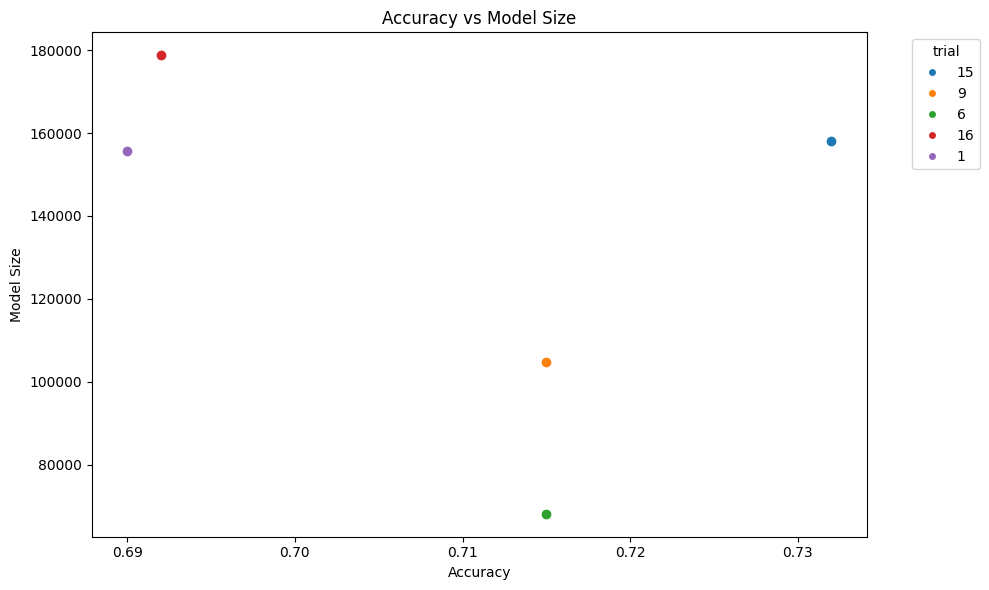

In [102]:
results = add_efficiency_metrics(study, best_k_trials)

results_df = pd.DataFrame(results).T
results_df = results_df.astype({'trial': 'int64', 'model_size': 'int64'})

plot_model_metrics(results_df)

<a name='6'></a>
## 6 - (Opcional) Evaluando el modelo con métricas alternativas

Ahora eres un vendedor de arte digital auténtico y estás utilizando el sistema AI Explorer para asistirte en la reventa de obras de arte disponibles, que incluyen tanto piezas reales como falsas. Tu objetivo es asegurar que el arte que revendes es auténtico, clasificando con precisión cada pieza como real (etiquetada como 1) o falsa (etiquetada como 0).



En este entorno, te enfrentas a dos riesgos significativos:

- **Problema de Reputación**: Vender arte falso como real, lo que eventualmente conduce a una pérdida de reputación o desanima a la gente a comprar tu arte. Esto puede describirse como un error de Falso Positivo (FP). Aquí, el modelo clasifica erróneamente el arte falso como real, etiquetándolo como 1 cuando debería ser 0.
- **Problema de Beneficios**: No vender arte real porque lo clasificas como falso, lo que conduce a una pérdida de beneficios potenciales. Esto corresponde a un error de Falso Negativo (FN), donde el arte real se etiqueta incorrectamente como falso, asignándole un 0 en lugar de la etiqueta correcta 1.

Para evaluar el rendimiento de tu sistema en relación con ambos problemas, puedes emplear métricas como el Recall (Exhaustividad) y la Precision (Precisión).

- **Recall** ayuda a asegurar que el arte real sea identificado correctamente, minimizando los errores FN y aumentando el número de piezas disponibles para vender. Es el porcentaje de piezas de arte real reales que se clasifican correctamente. Los valores de Recall oscilan entre 0 y 1, donde los valores cercanos a 1 indican menos errores FN, lo que significa que se identifica correctamente más arte real y está disponible para la venta.

- **Precision** se enfoca en identificar correctamente las piezas falsas, reduciendo los errores FP y protegiendo tu reputación. Es el porcentaje de piezas identificadas como arte real que son realmente reales. La Precision también oscila entre 0 y 1, donde los valores cercanos a 1 indican menos errores FP, mejorando así tu credibilidad al asegurar que no se venda arte falso como real.

Al analizar tu sistema con estas métricas en mente, puedes equilibrar el mantenimiento de tu credibilidad y la maximización de tu potencial de ventas.

<a name='6-1'></a>
### 6.1 - Precision y Recall

En esta sección, explorarás cómo calcular métricas adicionales como Precision y Recall para los mejores k trials del estudio de Optuna.
Esto te ayudará a comprender los compromisos (trade-offs) entre diferentes métricas y cómo pueden utilizarse para evaluar el rendimiento de tus modelos de una manera más matizada.

Utilizarás la librería `torchmetrics` para calcular estas métricas, la cual proporciona una forma sencilla y eficiente de computar varias métricas de evaluación para modelos de PyTorch.
En esta sección opcional final, volverás a entrenar los mejores k modelos del estudio de Optuna y los evaluarás utilizando las métricas de Accuracy, Precision y Recall. La función `train_with_alternative_metrics` contiene la lógica para extraer los parámetros del modelo del trial de Optuna, crear un nuevo modelo con esos parámetros y luego entrenar y evaluar el modelo utilizando las métricas especificadas.

In [104]:
def train_with_alternative_metrics(study, best_k_trials, device, dataset_path):
    """
    Entrena una selección de modelos y los evalúa utilizando múltiples métricas.

    Args:
        study: El objeto de estudio de Optuna.
        best_k_trials: Un DataFrame de las mejores K pruebas para ser re-evaluadas.
        device: El dispositivo (por ejemplo, 'cpu' o 'cuda') para realizar el entrenamiento y la evaluación.
        dataset_path: La ruta del archivo del conjunto de datos.

    Returns:
        Un diccionario que contiene las métricas de evaluación para cada prueba.
    """
    # Extraer los índices de las mejores k pruebas
    idx_trials = best_k_trials.index.tolist()
    # Inicializar un diccionario para almacenar los resultados
    results = {}

    # Iterar sobre los índices de las mejores pruebas
    for i in idx_trials:
        # Obtener el objeto de prueba del estudio
        trial = study.get_trials(deepcopy=True)[i]
        # Extraer los parámetros del modelo de la prueba
        params_model = trial.params

        # Extraer parámetros del modelo de los parámetros de la prueba
        n_layers = params_model["n_layers"]
        # Crear una lista del número de filtros para cada capa convolucional
        n_filters = [params_model[f"n_filters_layer{j}"] for j in range(n_layers)]
        # Crear una lista de los tamaños de kernel para cada capa convolucional
        kernel_sizes = [params_model[f"kernel_size_layer{j}"] for j in range(n_layers)]
        # Extraer la tasa de dropout
        dropout_rate = params_model["dropout_rate"]
        # Extraer el tamaño de la capa fully connected
        fc_size = params_model["fc_size"]

        # Instanciar un nuevo modelo con los parámetros extraídos
        model_trial = FlexibleCNN(
            n_layers=n_layers,
            n_filters=n_filters,
            kernel_sizes=kernel_sizes,
            dropout_rate=dropout_rate,
            fc_size=fc_size,
            num_classes=2
        )

        # Inicializar capas dinámicas antes de definir el optimizador
        resolution = params_model["resolution"]
        dummy_input = torch.randn(1, 3, resolution, resolution).to(device)
        model_trial = model_trial.to(device)
        model_trial(dummy_input)

        # Inicializar el optimizador para el modelo
        optimizer = optim.Adam(model_trial.parameters(), lr=params_model['learning_rate'])
        # Definir la función de pérdida
        loss_fcn = nn.CrossEntropyLoss()

        # Obtener los data loaders para entrenamiento y validación
        train_loader, val_loader = get_data_loaders(
            transforms.Compose([
                transforms.Resize((params_model["resolution"], params_model["resolution"])),
                transforms.ToTensor(),
            ]),
            params_model["batch_size"],
            AIvsReal_path=dataset_path
        )

        # Establecer el número de épocas de entrenamiento
        n_epochs = 3
        # Mover el modelo al dispositivo especificado
        model_trial = model_trial.to(device)

        # Comenzar el bucle de entrenamiento
        for epoch in range(n_epochs):
            # Ejecutar una sola época de entrenamiento
            _ = training_epoch(
                model_trial,
                train_loader,
                optimizer,
                loss_fcn,
                device,
                epoch,
                n_epochs,
                silent=False,
            )

        # Inicializar las métricas de evaluación
        accuracy_metric = Accuracy(task="binary").to(device)
        precision_metric = Precision(task="binary").to(device)
        recall_metric = Recall(task="binary").to(device)

        # Establecer el modelo en modo de evaluación
        model_trial.eval()
        # Desactivar cálculos de gradientes para la evaluación
        with torch.no_grad():
            # Iterar a través de los datos de validación
            for inputs, labels in val_loader:
                # Mover datos al dispositivo especificado
                inputs, labels = inputs.to(device), labels.to(device)
                # Realizar un paso hacia adelante (forward pass)
                outputs = model_trial(inputs)
                # Obtener la clase predicha
                preds = torch.argmax(outputs, dim=1)

                # Actualizar las métricas con las predicciones y etiquetas del batch actual
                accuracy_metric.update(preds, labels)
                precision_metric.update(preds, labels)
                recall_metric.update(preds, labels)

        # Calcular las puntuaciones finales de las métricas y almacenarlas en el diccionario de resultados
        results[i] = {
            'trial': i,
            'accuracy': accuracy_metric.compute().item(),
            'precision': precision_metric.compute().item(),
            'recall': recall_metric.compute().item(),
        }

    # Devolver el diccionario de resultados
    return results

In [105]:
# NOTE: It takes about 16 minutes to run
results_alt = train_with_alternative_metrics(study=study, best_k_trials=best_k_trials, device=DEVICE, dataset_path=AIvsReal_path)

Epoch 1/3 - Training:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1/3], Step [45/250], Loss: 0.6776
Epoch [1/3], Step [90/250], Loss: 0.7139


/home/keras/wordspaces/Pytorch-for-Deep-Learning/.venv/lib/python3.12/site-packages/PIL/Image.py:1034: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/3], Step [135/250], Loss: 0.5521
Epoch [1/3], Step [180/250], Loss: 0.6294
Epoch [1/3], Step [225/250], Loss: 0.7680


Epoch 2/3 - Training:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [2/3], Step [45/250], Loss: 0.5485
Epoch [2/3], Step [90/250], Loss: 0.5036
Epoch [2/3], Step [135/250], Loss: 0.5694
Epoch [2/3], Step [180/250], Loss: 0.8482
Epoch [2/3], Step [225/250], Loss: 0.6030


Epoch 3/3 - Training:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [3/3], Step [45/250], Loss: 0.4613
Epoch [3/3], Step [90/250], Loss: 0.7026
Epoch [3/3], Step [135/250], Loss: 0.6191
Epoch [3/3], Step [180/250], Loss: 0.4715
Epoch [3/3], Step [225/250], Loss: 0.3945


Epoch 1/3 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/3], Step [45/500], Loss: 0.7904
Epoch [1/3], Step [90/500], Loss: 0.8429
Epoch [1/3], Step [135/500], Loss: 0.5732
Epoch [1/3], Step [180/500], Loss: 0.7184
Epoch [1/3], Step [225/500], Loss: 0.6368
Epoch [1/3], Step [270/500], Loss: 0.6294
Epoch [1/3], Step [315/500], Loss: 0.7182
Epoch [1/3], Step [360/500], Loss: 0.7279
Epoch [1/3], Step [405/500], Loss: 0.5487
Epoch [1/3], Step [450/500], Loss: 0.6918
Epoch [1/3], Step [495/500], Loss: 0.6713


Epoch 2/3 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/3], Step [45/500], Loss: 0.5933
Epoch [2/3], Step [90/500], Loss: 0.5639
Epoch [2/3], Step [135/500], Loss: 0.6599
Epoch [2/3], Step [180/500], Loss: 0.5918
Epoch [2/3], Step [225/500], Loss: 0.6834
Epoch [2/3], Step [270/500], Loss: 0.5048
Epoch [2/3], Step [315/500], Loss: 0.5974
Epoch [2/3], Step [360/500], Loss: 0.7512
Epoch [2/3], Step [405/500], Loss: 0.4648
Epoch [2/3], Step [450/500], Loss: 0.6943
Epoch [2/3], Step [495/500], Loss: 0.6966


Epoch 3/3 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/3], Step [45/500], Loss: 0.5354
Epoch [3/3], Step [90/500], Loss: 0.5169
Epoch [3/3], Step [135/500], Loss: 0.4813
Epoch [3/3], Step [180/500], Loss: 0.7218
Epoch [3/3], Step [225/500], Loss: 0.5438
Epoch [3/3], Step [270/500], Loss: 0.4543
Epoch [3/3], Step [315/500], Loss: 0.5918
Epoch [3/3], Step [360/500], Loss: 0.3816
Epoch [3/3], Step [405/500], Loss: 0.6270
Epoch [3/3], Step [450/500], Loss: 0.4734
Epoch [3/3], Step [495/500], Loss: 0.6751


Epoch 1/3 - Training:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1/3], Step [45/250], Loss: 0.6900
Epoch [1/3], Step [90/250], Loss: 0.7689
Epoch [1/3], Step [135/250], Loss: 0.6734
Epoch [1/3], Step [180/250], Loss: 0.7484
Epoch [1/3], Step [225/250], Loss: 0.5554


Epoch 2/3 - Training:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [2/3], Step [45/250], Loss: 0.6564
Epoch [2/3], Step [90/250], Loss: 0.4455
Epoch [2/3], Step [135/250], Loss: 0.6590
Epoch [2/3], Step [180/250], Loss: 0.4750
Epoch [2/3], Step [225/250], Loss: 0.5556


Epoch 3/3 - Training:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [3/3], Step [45/250], Loss: 0.4638
Epoch [3/3], Step [90/250], Loss: 0.7246
Epoch [3/3], Step [135/250], Loss: 0.6653
Epoch [3/3], Step [180/250], Loss: 0.7527
Epoch [3/3], Step [225/250], Loss: 0.5423


Epoch 1/3 - Training:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1/3], Step [45/250], Loss: 0.6223
Epoch [1/3], Step [90/250], Loss: 0.6216
Epoch [1/3], Step [135/250], Loss: 0.6522
Epoch [1/3], Step [180/250], Loss: 0.6162
Epoch [1/3], Step [225/250], Loss: 0.6777


Epoch 2/3 - Training:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [2/3], Step [45/250], Loss: 0.6165
Epoch [2/3], Step [90/250], Loss: 0.5811
Epoch [2/3], Step [135/250], Loss: 0.6504
Epoch [2/3], Step [180/250], Loss: 0.5800
Epoch [2/3], Step [225/250], Loss: 0.6035


Epoch 3/3 - Training:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [3/3], Step [45/250], Loss: 0.4664
Epoch [3/3], Step [90/250], Loss: 0.6344
Epoch [3/3], Step [135/250], Loss: 0.7023
Epoch [3/3], Step [180/250], Loss: 0.6681
Epoch [3/3], Step [225/250], Loss: 0.4771


Epoch 1/3 - Training:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1/3], Step [45/250], Loss: 0.5865
Epoch [1/3], Step [90/250], Loss: 0.5666
Epoch [1/3], Step [135/250], Loss: 0.8715
Epoch [1/3], Step [180/250], Loss: 0.5619
Epoch [1/3], Step [225/250], Loss: 0.6154


Epoch 2/3 - Training:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [2/3], Step [45/250], Loss: 0.7178
Epoch [2/3], Step [90/250], Loss: 0.6523
Epoch [2/3], Step [135/250], Loss: 0.8934
Epoch [2/3], Step [180/250], Loss: 0.5971
Epoch [2/3], Step [225/250], Loss: 0.6715


Epoch 3/3 - Training:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [3/3], Step [45/250], Loss: 0.4894
Epoch [3/3], Step [90/250], Loss: 0.6961
Epoch [3/3], Step [135/250], Loss: 0.5429
Epoch [3/3], Step [180/250], Loss: 0.4920
Epoch [3/3], Step [225/250], Loss: 0.6250


In [106]:
def plot_metric_scatter(df, x_col="accuracy", y_col="precision", color_col="recall", label_col="trial"):
    """
    Crea un gráfico de dispersión para visualizar la relación entre dos métricas,
    con una tercera métrica representada por el color.

    Args:
        df: Un DataFrame de pandas que contiene los datos a graficar.
        x_col: El nombre de la columna a usar para el eje x.
        y_col: El nombre de la columna a usar para el eje y.
        color_col: El nombre de la columna a usar para los colores de los puntos.
        label_col: El nombre de la columna a usar para etiquetar cada punto.
    """
    # Crear una nueva figura y ejes para el gráfico
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Normalizar los valores de color y definir el mapa de colores (colormap)
    color_values = df[color_col]
    # Crear un objeto de normalización para el rango de colores
    norm = mpl.colors.Normalize(vmin=color_values.min(), vmax=color_values.max())
    # Definir el mapa de colores a ser utilizado
    cmap = plt.cm.viridis

    # Crear el gráfico de dispersión
    scatter = ax.scatter(
        df[x_col],
        df[y_col],
        c=color_values,
        cmap=cmap,
        norm=norm,
        s=100,
        edgecolor='k',
        alpha=0.8
    )

    # Añadir una barra de color (colorbar) al gráfico
    cbar = plt.colorbar(scatter, ax=ax)
    # Establecer la etiqueta para la barra de color
    cbar.set_label(color_col.capitalize())

    # Añadir etiquetas de texto a cada punto en el gráfico
    for _, row in df.iterrows():
        ax.text(
            row[x_col],
            row[y_col],
            str(row[label_col]),
            fontsize=9,
            ha='center',
            va='center',
            color='white',
        )

    # Establecer las etiquetas y el título del gráfico
    ax.set_xlabel(x_col.capitalize())
    ax.set_ylabel(y_col.capitalize())
    ax.set_title(f"{y_col.capitalize()} vs {x_col.capitalize()} (coloreado por {color_col.capitalize()})")
    # Ajustar los parámetros del gráfico para un diseño apretado
    plt.tight_layout()
    # Mostrar el gráfico
    plt.show()

Ahora puedes observar qué tan buenos son tus modelos en términos de accuracy, precision (también conocida como reputación) y recall (también conocida como beneficios).

In [107]:
results_df_metrics = pd.DataFrame(results_alt).T
results_df_metrics = results_df_metrics.astype({'trial': 'Int64'})

print(results_df_metrics)

# get the best model based on precision
best_precision_trial = results_df_metrics.loc[results_df_metrics['precision'].idxmax()]
print(f"Best model based on precision: Trial {best_precision_trial['trial']} with Precision: {best_precision_trial['precision']:.4f}, Recall: {best_precision_trial['recall']:.4f}, Accuracy: {best_precision_trial['accuracy']:.4f}")

    trial  accuracy  precision    recall
15     15     0.626   0.571633  0.841772
9       9     0.605   0.622378  0.534000
6       6     0.700   0.673367  0.792899
16     16     0.694   0.664992  0.789264
1       1     0.666   0.616176  0.851626
Best model based on precision: Trial 6.0 with Precision: 0.6734, Recall: 0.7929, Accuracy: 0.7000


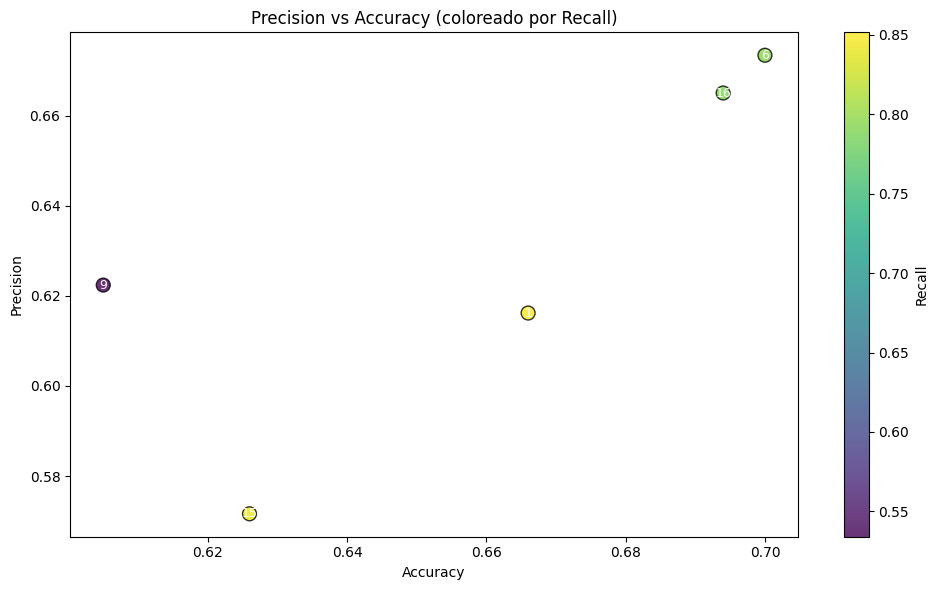

In [108]:
plot_metric_scatter(results_df_metrics)

Por lo tanto, si tu énfasis está en la reputación, puedes elegir el modelo con la precision más alta. 
Para seleccionar un modelo con un buen equilibrio entre precision y accuracy, considera explorar la región hacia la esquina derecha.


Ahora has añadido la capacidad de evaluar tus modelos utilizando métricas alternativas como Precision y Recall, lo que puede ayudarte a tomar decisiones más informadas sobre qué modelos desplegar basándote en tus necesidades comerciales específicas.
Esto concluye la sección opcional sobre métricas alternativas.

## Conclusión

¡Excelente trabajo, AI Explorer! Has completado con éxito tu misión de construir el **FakeFinder**, dominando un flujo de trabajo de AutoML potente y moderno de principio a fin. Diseñaste una `FlexibleCNN` dinámica, creaste un espacio de búsqueda sofisticado con **Optuna** e implementaste la función objetivo que guio el proceso de descubrimiento automatizado. Al ir más allá del simple accuracy para analizar la eficiencia del modelo con métricas como parámetros entrenables, precision y recall, has aprendido a equilibrar el rendimiento con las restricciones prácticas del mundo real.

Las habilidades que has desarrollado están a la vanguardia de la IA, donde la automatización del descubrimiento de modelos es una técnica esencial para resolver problemas complejos. Ahora estás bien equipado con las herramientas y la mentalidad para construir y evaluar modelos basados en objetivos de negocio específicos, una capacidad que será invaluable a medida que te enfrentes a desafíos aún más ambiciosos. ¡Felicitaciones por una expedición exitosa y mucha suerte en tu próxima aventura!